In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lxml

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import statsmodels.api as sm


## Load data
url = "https://www.basketball-reference.com/leagues/NBA_2023_per_game.html"

nba_data = pd.read_html(url, header=0)[0]
nba_data.head()

/Users/cameronmiller/venv/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Precious Achiuwa,C,23,TOR,35,11,23.6,4.0,8.2,...,.691,2.1,4.6,6.7,1.0,0.7,0.7,1.2,2.2,10.5
1,2,Steven Adams,C,29,MEM,42,42,27.0,3.7,6.3,...,.364,5.1,6.5,11.5,2.3,0.9,1.1,1.9,2.3,8.6
2,3,Bam Adebayo,C,25,MIA,54,54,35.4,8.5,15.7,...,.805,2.7,7.3,10.0,3.3,1.2,0.8,2.5,2.8,21.6
3,4,Ochai Agbaji,SG,22,UTA,37,2,15.1,1.7,3.5,...,.625,0.6,1.0,1.7,0.5,0.1,0.1,0.3,1.4,4.6
4,5,Santi Aldama,PF,22,MEM,54,18,22.1,3.4,7.1,...,.738,1.0,3.7,4.7,1.2,0.7,0.7,0.7,1.9,9.5


In [2]:
nba_data.columns

Index(['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

## Clean Data

In [3]:
def drop_rows_containing_string(df, col, string_value):
    mask = df[col].str.contains(string_value)
    df = df[~mask]
    return df

def convert_to_float(df, cols):
    for col in cols:
        df[col] = df[col].astype(float)
    return df


def create_name_column(df, name_list, column_name):
    df[column_name] = 0
    df.loc[df['Player'].isin(name_list), column_name] = 1
    return df

def row_number_by_player(df, player_col, sort_col):
    # Sort the DataFrame by the player column and the sort column
    df_sorted = df.sort_values([player_col, sort_col])

    # Create a new column to hold the row numbers
    df_sorted['row_number'] = (df_sorted.groupby(player_col).cumcount() + 1)

    # Return the sorted DataFrame with the row numbers
    return df_sorted


In [4]:
nba_data = row_number_by_player(nba_data, 'Player','G')
nba_data = nba_data[nba_data['row_number']==1]

In [5]:
## run both functions

features = ['Age', 'G', 'MP', 'FG%',
       '3P', '3PA', '3P%', '2P%', 'eFG%', 'FTA', 'FT%',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']

## remove rows that have string values likes PTS 
cleaned_nba_data = drop_rows_containing_string(nba_data, 'PTS','PTS')
## convert all object data types to float values
final = convert_to_float(cleaned_nba_data, features)
## validate all types are correct
print(final[features].dtypes)

Age     float64
G       float64
MP      float64
FG%     float64
3P      float64
3PA     float64
3P%     float64
2P%     float64
eFG%    float64
FTA     float64
FT%     float64
TRB     float64
AST     float64
STL     float64
BLK     float64
TOV     float64
PTS     float64
dtype: object


/var/folders/kk/3t_9_04x00gdsrmnsjw1d8rw0000gn/T/ipykernel_22642/1458449694.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(float)


## Build Kmeans Model

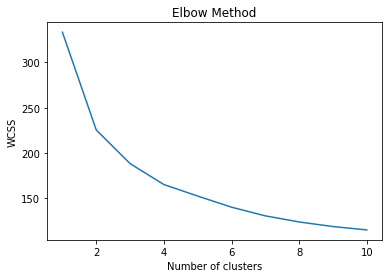

1.0    188
0.0    175
2.0     79
3.0     37
4.0     27
Name: ClusterLabel, dtype: int64
                    Age          G         MP       FG%        3P       3PA  \
ClusterLabel                                                                  
0.0           25.516129  37.733871  20.641935  0.467540  1.021774  2.854839   
1.0           25.992308  35.146154  21.240000  0.452738  1.078462  3.113077   
2.0           26.418182  37.090909  21.463636  0.480764  1.209091  3.290909   
3.0           26.758621  38.827586  20.627586  0.456586  1.086207  2.896552   
4.0           28.500000  40.166667  22.394444  0.460389  1.250000  3.472222   

                   3P%       2P%      eFG%       FTA       FT%       TRB  \
ClusterLabel                                                               
0.0           0.325919  0.542540  0.536694  1.811290  0.749879  3.533065   
1.0           0.316846  0.521300  0.520469  2.308462  0.770831  3.762308   
2.0           0.329818  0.548127  0.556745  2.263636  

In [6]:

# Extract the relevant features
data = final[features]

data = data.fillna(0)

# # Normalize the data
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data))
data

# # Step 2: Determine the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Step 3: Run the k-means algorithm
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(data)

# Step 4: Analyze the results
cluster_labels = pd.DataFrame(pred_y, columns=['ClusterLabel'])
result_df = pd.concat([final, cluster_labels], axis=1)

# print the number of players in each cluster
print(result_df['ClusterLabel'].value_counts())


## drop nulls
result_df.dropna(inplace=True)

print(result_df.groupby('ClusterLabel')[features].mean())



## What's the best way to predict an all-star?
### 1/ K-means Clustering
### 2/ Logistic Regression
### 3/ Hueristics [PPG] 

### Create a list of all-stars from 2023 roster!

In [7]:
actual_all_stars = ['LeBron James',
                  'Stephen Curry', 
                  'Kevin Durant', 
                  'Joel Embiid', 
                  'Luka Dončić', 
                  'Giannis Antetokounmpo', 
                  'Nikola Jokić', 
                  'Kyrie Irving', 
                  'James Harden', 
                  'Jayson Tatum', 
                  'Bradley Beal', 
                  'Donovan Mitchell',
                  'Bam Adebayo',
                  'Jaylen Brown',
                  'Tyrese Haliburton',
                  'Jrue Holiday',
                  'DeMar Derozan',
                  'Julius Randle',
                  'Pascal Siakam',
                  'Lauri Markkanen',
                  'Zion Williamson',
                  'Anthony Edwards',
                  "De'Aaron Fox",
                  'Paul George',
                  'Shai Gilgeous-Alexander',
                  'Jaren Jackson Jr.',
                  'Damian Lillard',
                  'Domantas Sabonis',
                  'Ja Morant']


result_df = create_name_column(result_df, actual_all_stars, 'All Star')

### 1/ K Means
#### If we create clusters based on the players in season statistics, we should be able to reasonably isolate high and low performers. The plot below shows us that cluster 2 would capture 10% of all named all-stars, but unfortunately we see a wide distribution of all-star presence in 3 out of the 4 clusters formed. 

<AxesSubplot:xlabel='ClusterLabel', ylabel='All Star'>

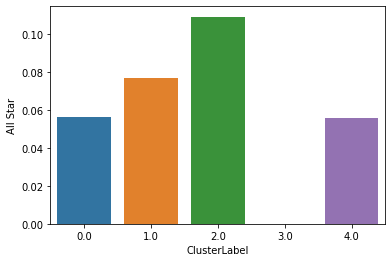

In [8]:
all_star_plt = result_df.groupby('ClusterLabel')['All Star'].mean().reset_index()
sns.barplot(data=all_star_plt, x='ClusterLabel',y='All Star')

### 2/ Logistic Regression
#### We can use a classification model to predict all-star status, based on having 2023 all-stars roster being annouced last week. We see a really strong r-squared , explaining 88% of the variance for the target ['all star']. If we go ahead and use the model to predict which players the model would classify as an all-star, we 9 players missed in total. 

#### Predicated All Stars, but NOT actually: ['Anthony Davis']
#### Actual All Stars, but NOT predicted: ['Bradley Beal', 'Jaren Jackson Jr.', 'Zion Williamson', 'Domantas Sabonis', 'DeMar Derozan', 'Julius Randle', 'Jayson Tatum', 'Pascal Siakam']

In [9]:
# select the relevant columns for the model
target = 'All Star'

# fit a logistic regression model
model = sm.Logit(result_df[target], sm.add_constant(result_df[features]))
result = model.fit()

# print the summary of the model
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.028645
         Iterations 17
                           Logit Regression Results                           
Dep. Variable:               All Star   No. Observations:                  356
Model:                          Logit   Df Residuals:                      338
Method:                           MLE   Df Model:                           17
Date:                Thu, 16 Feb 2023   Pseudo R-squ.:                  0.8840
Time:                        12:55:45   Log-Likelihood:                -10.197
converged:                       True   LL-Null:                       -87.897
Covariance Type:            nonrobust   LLR p-value:                 2.137e-24
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -95.2542     56.675     -1.681      0.093    -206.335      15.827
Age            0.0309      0

In [16]:
# predict the probabilities of being an all-star
probas = result.predict(sm.add_constant(result_df[features]))

# set the threshold for being an all-star
threshold = 0.5

# which is a common threshold value used in binary classification problems. 
# This means that if the predicted probability of a player being an all-star is greater than or equal to 0.5, the model predicts that the player is an all-star,
# otherwise it predicts that the player is not an all-star.

# get the list of players who should have been all-stars
predicted_all_stars = result_df.loc[probas >= threshold, 'Player'].tolist()
print(predicted_all_stars)
print(len(predicted_all_stars))

['Anthony Davis', 'Anthony Edwards', 'Bam Adebayo', 'Damian Lillard', "De'Aaron Fox", 'Donovan Mitchell', 'Giannis Antetokounmpo', 'Ja Morant', 'James Harden', 'Jaylen Brown', 'Joel Embiid', 'Jrue Holiday', 'Kevin Durant', 'Kyrie Irving', 'Lauri Markkanen', 'LeBron James', 'Luka Dončić', 'Nikola Jokić', 'Paul George', 'Shai Gilgeous-Alexander', 'Stephen Curry', 'Tyrese Haliburton']
22


In [11]:
def compare_lists(list1, list2):
    actual_not_predicted = list(set(list1) - set(list2))
    predicted_not_actual = list(set(list2) - set(list1))

    return predicted_not_actual, actual_not_predicted


In [12]:
predicted_not_actual, actual_not_predicted = compare_lists(actual_all_stars, predicted_all_stars)

print("Predicated All Stars, but NOT actually:", predicted_not_actual)
print("Actual All Stars, but NOT predicted:", actual_not_predicted)

Predicated All Stars, but NOT actually: ['Anthony Davis']
Actual All Stars, but NOT predicted: ['Bradley Beal', 'Jaren Jackson Jr.', 'Zion Williamson', 'Domantas Sabonis', 'DeMar Derozan', 'Julius Randle', 'Jayson Tatum', 'Pascal Siakam']


### 3/ Hueristic
#### The league indexs a lot of points. The players who score the most , by definition are the most exciting and will likely recieve a lot of votes. Lastly, we can use a simple hueristic to infer for the future. Right now, 2 out of 3 all-stars selected were in the top 30 of scoring. If you were lazy, and wanted to just use PPG next year in predicting, it might be the easiest bet. 

In [13]:
## validate that the top scorers have allstar tags
df_sorted = result_df.sort_values(by='PTS', ascending=False)
top_scorers = df_sorted.head(30)
top_scorers['All Star'].mean()

0.6333333333333333